# Imports

In [ ]:
# General data science libraries
import pandas as pd
import numpy as np

# Pulling data from APIs, parsing JSON
import requests
import json

# Interfacing with Cloud Storage from Python
from google.cloud import storage

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, Image

# General utilities
import os
import time  # For system performance tracking

# Data preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Machine learning models
from sklearn.linear_model import LinearRegression

# Video processing libraries
import cv2  # OpenCV for video processing
from moviepy.editor import VideoFileClip  # For video editing and frame extraction
from matplotlib.image import imread

# Deep learning and computer vision
import tensorflow as tf  # TensorFlow for deep learning
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling3D, Dense
from tensorflow.keras.utils import Sequence
import torch

  if event.key is 'enter':



# ⚾ Goal of Challenge 4: Generate Statcast Data from Old Videos: Create a tool that extracts fundamental Statcast metrics (e.g., pitch speed, exit velocity) from archival game videos using computer vision.

## Approach
###  1. Build Hit Distance Regression Model from Tabular Data & Advanced Feature Engineering
### 2. Build Exit Velocity & Launch angle prediction model from video.

**The goal therefore is to limit the number of frames the Video processing model has to handle since it would only need to see those on which the batter makes contact with the ball. One advantage of this is to reduce computational constraints and potentially allow real time distance traveled forecasts!**

In [ ]:
#@title Get 2024 MLB Home Runs Data from Cloud Storage
mlb_2024_hr_csv = 'https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/2024-mlb-homeruns.csv'

mlb_2024_hr_df = pd.read_csv(mlb_2024_hr_csv)

display(mlb_2024_hr_df.head())

,play_id,title,ExitVelocity,HitDistance,LaunchAngle,video
0,148e943b-10db-4d71-943d-ead3b36bebbc,Freddie Freeman homers (1) on a fly ball to ce...,101.7,408.819710,33.0,https://sporty-clips.mlb.com/eVozQWVfWGw0TUFRP...
1,d4116f91-e362-4261-a7d0-fc02f0eeb67b,Mookie Betts homers (2) on a fly ball to left ...,104.6,406.399234,28.0,https://sporty-clips.mlb.com/eVozQWVfWGw0TUFRP...
2,2d6363ad-8ff2-49cc-bf21-d8cdfdc55999,George Springer homers (1) on a fly ball to le...,100.3,391.587326,26.0,https://sporty-clips.mlb.com/WmU5ZDhfWGw0TUFRP...
3,e97b2fb3-a7b9-4a4b-812a-f1204437a06f,Paul Goldschmidt homers (1) on a fly ball to l...,101.8,401.081700,28.0,https://sporty-clips.mlb.com/eVozQWVfWGw0TUFRP...
4,3423ed8c-5945-46e0-89f4-d6ed2baf5696,Nick Martini homers (2) on a fly ball to right...,100.8,389.299792,23.0,https://sporty-clips.mlb.com/a1puZ0JfWGw0TUFRP...


In [ ]:
#@title Outliers? 0 hit distance Home Runs!!!?
def highlight_zero(data):
    styles = pd.DataFrame('', index=data.index, columns=data.columns)  # Default styles
    styles.loc[data['HitDistance'] == 0, 'HitDistance'] = 'background-color: yellow'  # Highlight zeros
    return styles

styled_df = pd.DataFrame(mlb_2024_hr_df.describe()).style.apply(highlight_zero, axis=None)
display(styled_df)
outliers = mlb_2024_hr_df[mlb_2024_hr_df['HitDistance'] < 315] # Minimum Distance to hit it out of the park

outliers.sort_values('HitDistance', ascending=False)

,ExitVelocity,HitDistance,LaunchAngle
count,5444.000000,5450.000000,5444.000000
mean,104.318038,397.550825,28.709037
std,4.333120,28.372278,5.167969
min,86.500000,0.000000,14.000000
25%,101.500000,380.571954,25.000000
50%,104.400000,398.959725,28.000000
75%,107.200000,415.054253,32.000000
max,119.900000,480.246737,50.000000


,play_id,title,ExitVelocity,HitDistance,LaunchAngle,video
2065,349fcd4d-0b4a-4ccb-9168-7c55050120c5,Elly De La Cruz hits an inside-the-park home r...,86.5,282.0,21.0,https://sporty-clips.mlb.com/YUs5bjZfWGw0TUFRP...
693,73d7f866-1d66-4cf7-b82a-02f72888772e,Jackson Chourio hits an inside-the-park home r...,87.8,264.0,16.0,https://sporty-clips.mlb.com/QVlNajNfWGw0TUFRP...
28,f9da13db-9ddf-4262-85d4-5b6eb0c02c55,Pedro Pagés homers (2) on a fly ball to left c...,93.6,0.0,36.0,https://sporty-clips.mlb.com/N1oza0FfV0ZRVkV3d...
147,f262b43d-ffb4-4624-b02b-84410533df97,Bryce Harper homers (15) on a fly ball to righ...,107.2,0.0,36.0,https://sporty-clips.mlb.com/UGpMeDdfV0ZRVkV3d...
769,eb8152b5-da7b-45f9-b68d-3d8956a029f7,Oneil Cruz homers (13) on a fly ball to right ...,114.4,0.0,27.0,https://sporty-clips.mlb.com/MDNEVjJfWGw0TUFRP...
2105,ef06b278-f0ed-4950-a33f-771807f1ed81,Mookie Betts homers (19) on a fly ball to left...,99.2,0.0,36.0,https://sporty-clips.mlb.com/NU53UGVfWGw0TUFRP...
2813,e9320eb7-f07c-4c9c-afa5-1ebc26906418,Whit Merrifield homers (3) on a fly ball to le...,101.5,0.0,25.0,https://sporty-clips.mlb.com/UGpMeDdfV0ZRVkV3d...
4812,5176a407-b370-4c85-aafa-bf37f06a58e4,David Dahl homers (2) on a fly ball to right c...,104.3,0.0,37.0,https://sporty-clips.mlb.com/eFoxYnpfV0ZRVkV3d...


**Turns out some videos even in 2024 do not have a distance calculated!**

*Also, some players are exceptionally athletic! Able to make within the park home runs through sheer speed.*


## `1.` Neural Network Regression Hit Distance Prediction Model
- Key Innovations:
  - Extract ball direction from play by play title
  - Add physics kinematics properties from projectile motion

In [ ]:
# Feature engineering from title
def feature_engineering_titles(df):
    """
    This function takes a DataFrame with a 'title' column and creates three new columns ('left', 'center', 'right').
    Each new column is populated with 1 if the corresponding word ('left', 'center', or 'right') is present in the 'title'
    and 0 if none of those words are present.
    """
    df['left'] = df['title'].str.contains(r'\bleft\b', case=False, na=False).astype(int)
    df['center'] = df['title'].str.contains(r'\bcenter\b', case=False, na=False).astype(int)
    df['right'] = df['title'].str.contains(r'\bright\b', case=False, na=False).astype(int)

    return df

mlb_2024_hr_df = feature_engineering_titles(mlb_2024_hr_df)

In [ ]:
# Constants
g = 9.81  # Acceleration due to gravity in m/s²

# Feature engineering
def add_projectile_motion_features(df, velocity_col, angle_col):
    # Convert angles from degrees to radians
    df['LaunchAngle_rad'] = np.radians(df[angle_col])

    # Horizontal (cosine) and vertical (sine) velocity components
    df['ExitVelocity_cosine'] = df[velocity_col] * np.cos(df['LaunchAngle_rad'])
    df['ExitVelocity_sine'] = df[velocity_col] * np.sin(df['LaunchAngle_rad'])

    # Time of flight
    df['TimeOfFlight'] = 2 * df['ExitVelocity_sine'] / g

    return df

# Apply feature engineering to the dataset
mlb_2024_hr_df_clean = add_projectile_motion_features(mlb_2024_hr_df, 'ExitVelocity', 'LaunchAngle')
mlb_2024_hr_df_clean = mlb_2024_hr_df_clean[mlb_2024_hr_df_clean['HitDistance'] > 0]

  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 109964.6953 - val_loss: 577.9256
Epoch 2/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 461.1308 - val_loss: 428.4188
Epoch 3/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 399.0118 - val_loss: 398.2739
Epoch 4/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 370.8501 - val_loss: 378.3029
Epoch 5/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 369.1117 - val_loss: 366.0779
Epoch 6/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 323.5323 - val_loss: 345.6816
Epoch 7/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 318.4425 - val_loss: 337.9546
Epoch 8/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 304.6688 - val_loss: 333.1501
Epoch 9/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 297.8034 - val_loss: 323.4637
Epoch 10/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 292.8924 - val_loss: 321.0633
Epoch 11/500
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 277.5322 - val_loss: 31

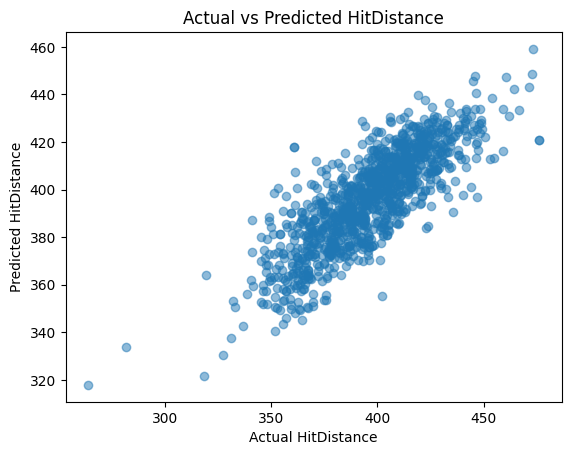

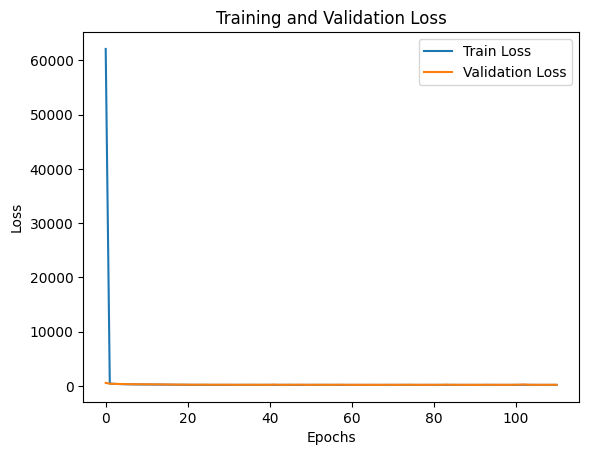

In [ ]:
# Define the features and target
feats = ['LaunchAngle_rad', 'ExitVelocity_cosine', 'ExitVelocity_sine',
         'TimeOfFlight', 'left', 'center', 'right']
target = 'HitDistance'

# Drop rows with missing values
mlb_2024_hr_df_clean = mlb_2024_hr_df_clean.dropna(subset=feats + [target])

# Split into train and test sets
X = mlb_2024_hr_df_clean[feats]
y = mlb_2024_hr_df_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = nn_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping])

# Predictions
y_pred = nn_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Visualize predictions vs actuals
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual HitDistance")
plt.ylabel("Predicted HitDistance")
plt.title("Actual vs Predicted HitDistance")
plt.show()

# Visualize the loss during training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Awesome a very good model! On average we are only ~15ft (square root of the Mean Squared Error) off target!**

- It is nearly a 20% performance improvement over the Linear Regression model which has a Mean Squared Error of 275.40. (*See Backlog Section Below*)
- Pure physics model needs more inputs from effects of Air resistance and friction. (*See Backlog Section Below*)
- NN model architecture optimization with Keras Tuner also utilized. (*See Backlog Section Below*)

**Possible Improvements**
- Engineer more features related to game conditions. Ie. Could get time of day, month game is played, field game is played at, temperature, wind speed, etc.

## `2.` Spatiotemporal Neural Network Video Exit Velocity & Launch Angle Prediction Model

In [ ]:
# Start from our clean data table
mlb_2024_hr_df_clean = mlb_2024_hr_df[mlb_2024_hr_df['HitDistance'] > 0]

In [ ]:
sample_n_videos = 10 #Sample 10 Videos due to computational constraints

# Create a folder to store videos
video_folder = '/content/videos'
os.makedirs(video_folder, exist_ok=True)

df = mlb_2024_hr_df_clean.sample(sample_n_videos).reset_index()

# Download videos
for idx, url in enumerate(df['video']):
    response = requests.get(url, stream=True)
    file_path = os.path.join(video_folder, f"video_{idx}.mp4")
    with open(file_path, 'wb') as f:
        f.write(response.content)
    df.at[idx, 'local_path'] = file_path

In [ ]:
# Extract the same Frames from each video
frame_folder = '/content/extracted_frames'
os.makedirs(frame_folder, exist_ok=True)

# Frame extraction parameters (Between 2 & 5 Seconds All Videos have the Batter make contact with the Ball)
start_time = 2
end_time = 5
frame_indices_to_keep = range(70, 121) # These frames on testing capture the moment of impact 98% of the time

# Extract Frames from each video
for idx, row in df.iterrows():
    video_path = row['local_path']
    cap = cv2.VideoCapture(video_path)

    video_fps = int(cap.get(cv2.CAP_PROP_FPS))
    if video_fps == 0:
        print(f"Warning: Unable to retrieve FPS for video {video_path}")
        continue

    start_frame = int(start_time * video_fps)
    end_frame = int(end_time * video_fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    frame_count = start_frame
    saved_count = 0

    while frame_count <= end_frame:
        success, frame = cap.read()
        if not success:
            print(f"Frame reading failed at frame {frame_count} in {video_path}")
            break

        if frame_count - start_frame in frame_indices_to_keep:
            frame_path = os.path.join(frame_folder, f"video_{idx}_frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {saved_count} frames from {video_path}")


Extracted 51 frames from /content/videos/video_0.mp4
Extracted 51 frames from /content/videos/video_1.mp4
Extracted 51 frames from /content/videos/video_2.mp4
Extracted 51 frames from /content/videos/video_3.mp4
Extracted 51 frames from /content/videos/video_4.mp4
Extracted 51 frames from /content/videos/video_5.mp4
Extracted 51 frames from /content/videos/video_6.mp4
Extracted 51 frames from /content/videos/video_7.mp4
Extracted 51 frames from /content/videos/video_8.mp4
Extracted 51 frames from /content/videos/video_9.mp4


In [ ]:
# Prepare Data for a Spatiotemporal Neural Network
class VideoDataGenerator(Sequence):
    def __init__(self, df, frame_folder, batch_size=2, max_frames=16):
        self.df = df
        self.frame_folder = frame_folder
        self.batch_size = batch_size
        self.max_frames = max_frames

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Get a batch of data
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []
        for idx, row in batch_df.iterrows():
            frames = self._preprocess_frames(idx)
            X.append(frames)
            y.append([row['ExitVelocity'], row['LaunchAngle']])
        return np.array(X), np.array(y)

    def _preprocess_frames(self, video_id):
        # Helper to preprocess and sample frames
        frame_paths = sorted([
            os.path.join(self.frame_folder, f) for f in os.listdir(self.frame_folder)
            if f.startswith(f"video_{video_id}_frame_")
        ])
        # Sample up to `max_frames` evenly for memory issues
        sampled_indices = np.linspace(0, len(frame_paths) - 1, self.max_frames, dtype=int)
        frames = [cv2.resize(cv2.imread(frame_paths[idx]), (112, 112)) for idx in sampled_indices]
        return np.array(frames)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

batch_size = 2
max_frames = 16 # Adjust as per memory limits

train_gen = VideoDataGenerator(train_df, frame_folder, batch_size=batch_size, max_frames=max_frames)
val_gen = VideoDataGenerator(val_df, frame_folder, batch_size=batch_size, max_frames=max_frames)

In [ ]:
input_shape = (None, 112, 112, 3) # Frames input shape

# Build the model
video_model = Sequential([
    TimeDistributed(
        tf.keras.applications.MobileNetV2(
            include_top=False, input_shape=(112, 112, 3), weights='imagenet'
        ), # Take advantage of transfer learning with MobileNetV2 model
        input_shape=input_shape
    ),
    GlobalAveragePooling3D(),
    Dense(128, activation='relu'),
    Dense(2)  # Output for ExitVelocity and LaunchAngle
])

# Compile the model
video_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

  tf.keras.applications.MobileNetV2(



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


  super().__init__(**kwargs)



In [ ]:
# Train the model
history_video_model = video_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    verbose=1
)

Epoch 1/10


  self._warn_if_super_not_called()



4/4 ━━━━━━━━━━━━━━━━━━━━ 398s 10s/step - loss: 5649.1709 - mae: 64.5546 - val_loss: 4350.9287 - val_mae: 58.3982
Epoch 2/10


  self.gen.throw(typ, value, traceback)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 4044.5996 - mae: 56.2153 - val_loss: 2676.1255 - val_mae: 47.5398
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 2327.2634 - mae: 42.3071 - val_loss: 721.3271 - val_mae: 25.5299
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 871.4364 - mae: 25.9101 - val_loss: 753.1046 - val_mae: 21.6602
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 144.3363 - mae: 9.1264 - val_loss: 3455.1707 - val_mae: 46.9292
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0000e+00 - mae: 0.0000e+00


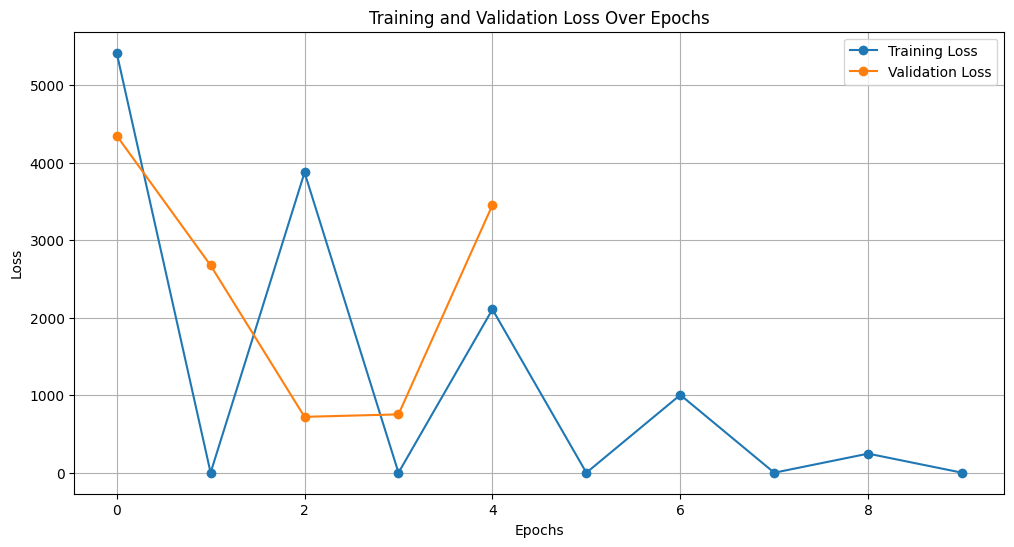

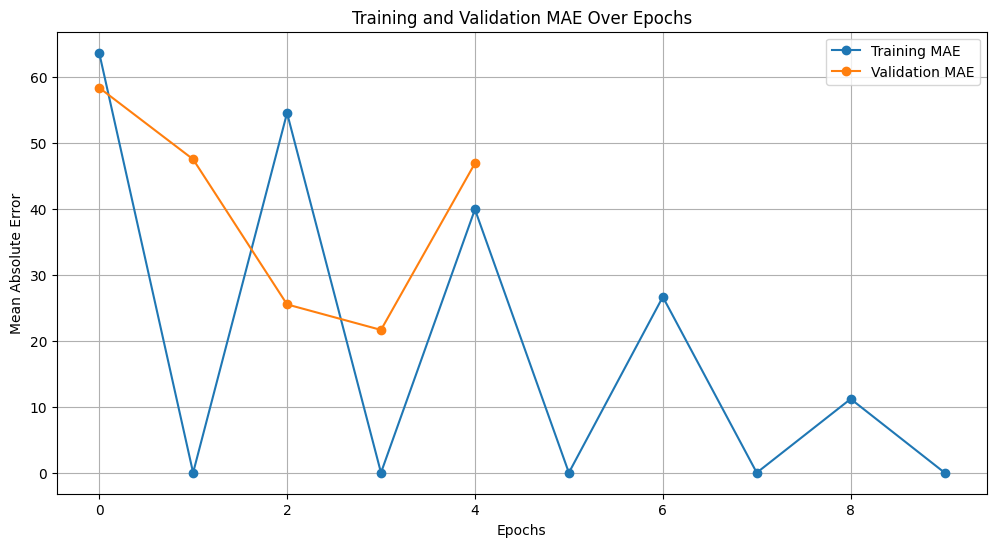

In [ ]:
# Extract metrics from the training history
train_loss = history_video_model.history['loss']
val_loss = history_video_model.history['val_loss']
train_mae = history_video_model.history['mae']
val_mae = history_video_model.history['val_mae']

# Plot the loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE', marker='o')
plt.plot(val_mae, label='Validation MAE', marker='o')
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Predict on the validation set
y_true = []
y_pred = []

for i in range(len(train_gen)):
    X_batch, y_batch = train_gen[i]
    y_true.append(y_batch)
    y_pred.append(video_model.predict(X_batch))

# Convert lists to numpy arrays for easier manipulation
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


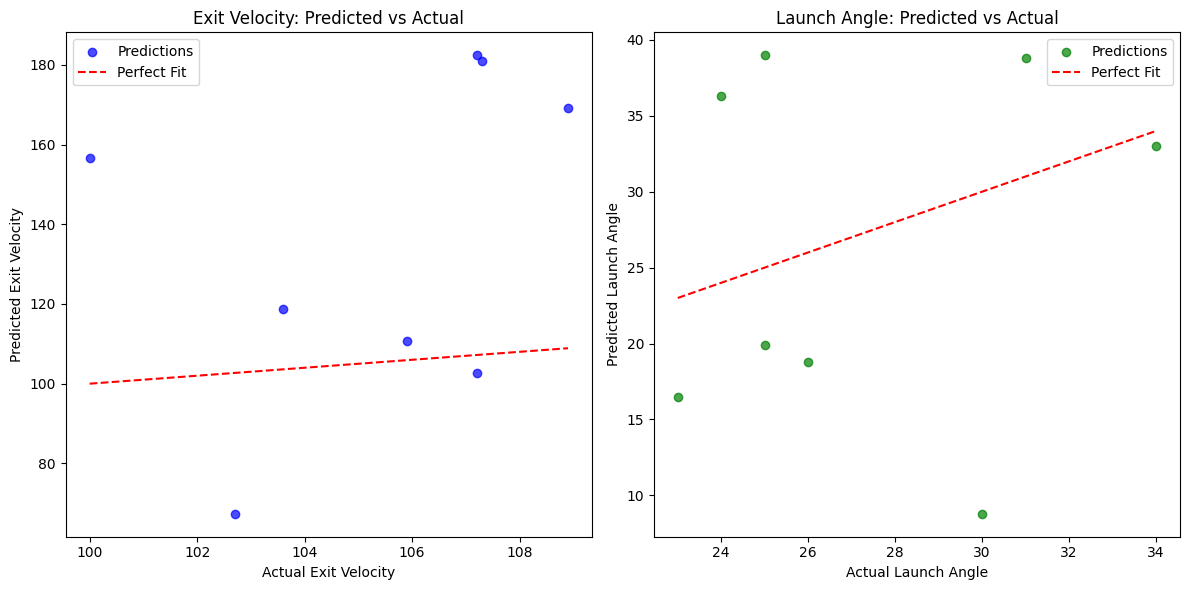

In [ ]:
# Create scatter plots
y_true_exit_velocity = y_true[:, 0]
y_pred_exit_velocity = y_pred[:, 0]
y_true_launch_angle = y_true[:, 1]
y_pred_launch_angle = y_pred[:, 1]


plt.figure(figsize=(12, 6))

# Exit Velocity
plt.subplot(1, 2, 1)
plt.scatter(y_true_exit_velocity, y_pred_exit_velocity, alpha=0.7, color='blue', label='Predictions')
plt.plot([y_true_exit_velocity.min(), y_true_exit_velocity.max()],
         [y_true_exit_velocity.min(), y_true_exit_velocity.max()],
         color='red', linestyle='--', label='Perfect Fit')
plt.title('Exit Velocity: Predicted vs Actual')
plt.xlabel('Actual Exit Velocity')
plt.ylabel('Predicted Exit Velocity')
plt.legend()

# Launch Angle
plt.subplot(1, 2, 2)
plt.scatter(y_true_launch_angle, y_pred_launch_angle, alpha=0.7, color='green', label='Predictions')
plt.plot([y_true_launch_angle.min(), y_true_launch_angle.max()],
         [y_true_launch_angle.min(), y_true_launch_angle.max()],
         color='red', linestyle='--', label='Perfect Fit')
plt.title('Launch Angle: Predicted vs Actual')
plt.xlabel('Actual Launch Angle')
plt.ylabel('Predicted Launch Angle')
plt.legend()

plt.tight_layout()
plt.show()


**An okay model that WILL improve with more training cycles and videos!**

**Possible Improvements**
- More efficient frame extraction (ie. have another meta model that only captures frames when the bat is in the strikezone)
- Image preprocessing techniques like masking to isolate the baseball and bat or other enhancements for frame quality


## 🧢 Putting it all together to hit a Home Run!

In [ ]:
#@title Get Historical 2016 MLB Home Runs Data from Cloud Storage
mlb_2016_hr_csv = 'https://storage.googleapis.com/gcp-mlb-hackathon-2025/datasets/2016-mlb-homeruns.csv'

mlb_2016_hr_df = pd.read_csv(mlb_2016_hr_csv)

video_url =mlb_2016_hr_df.sample(1)['video'].iloc[0]


HTML(f"""<video width="640" height="360" controls>
          <source src="{video_url}" type="video/mp4">
          Your browser does not support the video tag.
        </video>""")

In [ ]:
def predict_from_historical(df, nn_model = nn_model, video_model = video_model, frame_folder='historical_video_folder', max_frames=50, start_time=2, end_time=5):
    """
    Predict ExitVelocity and LaunchAngle from a video URL using the trained model.

    Parameters:
    - df (pd.DataFrame): Pandas dataframe row of data to predict on.
    - nn_model (keras.Model): Trained neural network model for HitDistance prediction.
    - model (keras.Model): Pretrained spatiotemporal model for ExitVelocity and LaunchAngle prediction.
    - frame_folder (str): Folder to save extracted frames.
    - max_frames (int): Maximum frames to process per video.
    - start_time (int): Start time in seconds for frame extraction.
    - end_time (int): End time in seconds for frame extraction.

    Returns:
    - predictions (np.array): Predicted ExitVelocity and LaunchAngle.
    """
    # Step 1: Download the video
    video_url =df['video'].iloc[0]
    response = requests.get(video_url, stream=True)
    os.makedirs(frame_folder, exist_ok=True)
    video_path = os.path.join(frame_folder, "temp_video.mp4")
    with open(video_path, "wb") as f:
        f.write(response.content)

    # Step 2: Extract Frames
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    if fps == 0:
        raise ValueError("Unable to retrieve FPS for the video.")

    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    frames = []
    frame_count = start_frame
    while frame_count <= end_frame:
        success, frame = cap.read()
        if not success:
            break

        frames.append(cv2.resize(frame, (112, 112)))  # Resize to model's input shape
        frame_count += 1

    cap.release()
    os.remove(video_path)  # Clean up the downloaded video

    # Step 3: Preprocess Frames
    frames = np.array(frames[:max_frames])  # Limit to max_frames
    if len(frames) < max_frames:
        # Pad with black frames if not enough frames
        padding = np.zeros((max_frames - len(frames), 112, 112, 3))
        frames = np.vstack([frames, padding])
    frames = frames / 255.0  # Normalize pixel values to [0, 1]

    # Step 4: Make ExitVelocity & LaunchAngle Predictions
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    predictions = video_model.predict(frames)

    # Step 5: Make HitDistance Predictions
    df['ExitVelocity'] = predictions[0][0]
    df['LaunchAngle'] = predictions[0][1]
    df = feature_engineering_titles(df)
    df = add_projectile_motion_features(df, 'ExitVelocity', 'LaunchAngle')
    predictions_hd = nn_model.predict(df[feats])[0][0]

    print(f"Predicted ExitVelocity: {predictions[0][0]}")
    print(f"Predicted LaunchAngle: {predictions[0][1]}")
    print(f"Predicted HitDistance: {predictions_hd}")

    return predictions[0][0], predictions_hd , predictions[0][1]   # Return ExitVelocity, HitDistance and LaunchAngle

In [ ]:
preds = predict_from_historical(mlb_2016_hr_df.sample(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted ExitVelocity: 71.72691345214844
Predicted LaunchAngle: 13.861187934875488
Predicted HitDistance: 221.06686401367188


# Backlog

In [ ]:
#@title Linear Regression Model for Hit Distance
# Feature engineering from title
def feature_engineering_titles(df):
    """
    This function takes a DataFrame with a 'title' column and creates three new columns ('left', 'center', 'right').
    Each new column is populated with 1 if the corresponding word ('left', 'center', or 'right') is present in the 'title'
    and 0 if none of those words are present.
    """
    df['left'] = df['title'].str.contains(r'\bleft\b', case=False, na=False).astype(int)
    df['center'] = df['title'].str.contains(r'\bcenter\b', case=False, na=False).astype(int)
    df['right'] = df['title'].str.contains(r'\bright\b', case=False, na=False).astype(int)

    return df

mlb_2024_hr_df = feature_engineering_titles(mlb_2024_hr_df)

# Constants
g = 9.81  # Acceleration due to gravity in m/s²

# Feature engineering
def add_projectile_motion_features(df, velocity_col, angle_col):
    # Convert angles from degrees to radians
    df['LaunchAngle_rad'] = np.radians(df[angle_col])

    # Horizontal (cosine) and vertical (sine) velocity components
    df['ExitVelocity_cosine'] = df[velocity_col] * np.cos(df['LaunchAngle_rad'])
    df['ExitVelocity_sine'] = df[velocity_col] * np.sin(df['LaunchAngle_rad'])

    # Time of flight
    df['TimeOfFlight'] = 2 * df['ExitVelocity_sine'] / g  # Assumes symmetric trajectory

    return df

# Apply feature engineering to the dataset
mlb_2024_hr_df_clean = add_projectile_motion_features(mlb_2024_hr_df, 'ExitVelocity', 'LaunchAngle')
mlb_2024_hr_df_clean = mlb_2024_hr_df_clean[mlb_2024_hr_df_clean['HitDistance'] > 0]

feats = ['LaunchAngle_rad', 'ExitVelocity_cosine', 'ExitVelocity_sine',
       'TimeOfFlight', 'left', 'center', 'right']
target = 'HitDistance'

# Drop rows with missing values
mlb_2024_hr_df_clean = mlb_2024_hr_df_clean.dropna(subset=feats + [target])

# Split into train and test sets
X = mlb_2024_hr_df_clean[feats]
y = mlb_2024_hr_df_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Visualize predictions vs actuals
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual HitDistance")
plt.ylabel("Predicted HitDistance")
plt.title("Actual vs Predicted HitDistance")
plt.show()

# Display the coefficients (linear regression weights)
coefficients = dict(zip(feats, model.coef_))
print("Model Coefficients:", coefficients)

In [ ]:
#@title Pure Physics Model
# Constants
g = 9.8  # Acceleration due to gravity in m/s²

# Approximation function for HitDistance
def calculate_hit_distance(row):
    v0 = row['ExitVelocity']*0.44704  # Initial velocity (m/s) converted from mph
    alpha = np.radians(row['LaunchAngle'])  # Convert angle to radians
    y0 = 3  # Assume Initial height (3 feet) converted to meters

    # Full kinematics formula
    d = (v0 * np.cos(alpha) / g) * (v0 * np.sin(alpha) + np.sqrt((v0 * np.sin(alpha))**2 + 2 * g * y0))
    return d*3.28084 # Convert back to feet

# Apply to dataset
mlb_2024_hr_df_clean['ApproxHitDistance'] = mlb_2024_hr_df_clean.apply(calculate_hit_distance, axis=1)

# Calculate MSE between actual and approximated hit distances
mse = mean_squared_error(mlb_2024_hr_df_clean['HitDistance'], mlb_2024_hr_df_clean['ApproxHitDistance'])

# Display MSE
print(f'Mean Squared Error (MSE): {mse}')

# Plotting the actual vs. approximated hit distances
plt.figure(figsize=(10, 6))
sns.scatterplot(x=mlb_2024_hr_df_clean['HitDistance'], y=mlb_2024_hr_df_clean['ApproxHitDistance'], color='blue', label='Predicted vs Actual')
plt.plot([mlb_2024_hr_df_clean['HitDistance'].min(), mlb_2024_hr_df_clean['HitDistance'].max()],
         [mlb_2024_hr_df_clean['HitDistance'].min(), mlb_2024_hr_df_clean['HitDistance'].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Hit Distance')
plt.ylabel('Approximated Hit Distance')
plt.title('Actual vs. Approximated Hit Distance')
plt.legend()
plt.show()

In [ ]:
#@title Optimize Neural Network Hit Distance Model with Keras Tuner

!pip install keras-tuner
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband
from tensorflow.keras.layers import Dense, Dropout

# Define the features and target
feats = ['LaunchAngle_rad', 'ExitVelocity_cosine', 'ExitVelocity_sine',
         'TimeOfFlight', 'left', 'center', 'right']
target = 'HitDistance'

# Drop rows with missing values
mlb_2024_hr_df_clean = mlb_2024_hr_df_clean.dropna(subset=feats + [target])

# Split into train and test sets
X = mlb_2024_hr_df_clean[feats]
y = mlb_2024_hr_df_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hypermodel for tuning
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # Add the input layer with hyperparameter search for the number of units
        model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=128, step=32), input_dim=X_train.shape[1], activation='relu'))

        # Add hidden layers with hyperparameter search for the number of units, activation function, and dropout rate
        for i in range(hp.Int('num_layers', 1, 3)):  # Search 1 to 3 hidden layers
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32), activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))

            # Add a dropout layer after each hidden layer
            # model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout rate search between 0.2 to 0.5

        # Add output layer
        model.add(Dense(1))  # Single output for regression

        # Compile the model with a learning rate search
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')), loss='mean_squared_error')
        return model

# Initialize Keras Tuner with Hyperband search strategy
tuner = Hyperband(
    MyHyperModel(),
    objective='val_loss',  # Optimize for validation loss
    max_epochs=100,  # Limit to 10 epochs for each trial
    factor=3,  # Search space reduction factor
    directory='kerastuner_dir',
    project_name='hit_distance_model'
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start tuning the model
tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters

# Evaluate the best model
y_pred = best_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Visualize predictions vs actuals
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual HitDistance")
plt.ylabel("Predicted HitDistance")
plt.title("Actual vs Predicted HitDistance")
plt.show()

# Optionally, print the best hyperparameters
print("Best Hyperparameters:")
print(best_hp.values)